https://docs.google.com/document/d/15GMxvJYAUO-b96c18QmfcF278IVVBBtCFk8nayDp9oY/edit

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import scipy as sp
from scipy import stats

from tools.plt import color2d #from the 'srcole/tools' repo
from matplotlib import cm
pd.options.display.max_rows = 1000

### Load dataframes

In [2]:
# Load cities info
df_cities = pd.read_csv('/gh/data2/yelp/city_pop.csv', index_col=0)
df_cities.head()

,city,state,population,total_food,latitude,longitude,total_scraped
0,New York,New York,8537673,54191,40.705445,-73.994293,1000
1,Los Angeles,California,3976322,41685,34.061590,-118.321381,1000
2,Chicago,Illinois,2704958,19315,41.905159,-87.677765,1000
3,Houston,Texas,2303482,15197,29.784854,-95.359955,1000
4,Phoenix,Arizona,1615017,11034,33.465086,-112.070160,1000


In [3]:
# Load restaurants
df_restaurants = pd.read_csv('/gh/data2/yelp/food_by_city/df_restaurants.csv', index_col=0)
df_restaurants.head()

,id,name,city,state,rating,review_count,cost,latitude,longitude,has_delivery,has_pickup,url
0,poquito-picante-brooklyn-2,Poquito Picante,New York,New York,4.5,40,2,40.685742,-73.981262,True,True,https://www.yelp.com/biz/poquito-picante-brook...
1,nourish-brooklyn-4,Nourish,New York,New York,4.0,65,2,40.677960,-73.968550,True,True,https://www.yelp.com/biz/nourish-brooklyn-4?ad...
2,taste-of-heaven-brooklyn,Taste of Heaven,New York,New York,5.0,19,2,40.717150,-73.940540,False,True,https://www.yelp.com/biz/taste-of-heaven-brook...
3,milk-and-cream-cereal-bar-new-york,Milk & Cream Cereal Bar,New York,New York,4.5,307,2,40.719580,-73.996540,False,False,https://www.yelp.com/biz/milk-and-cream-cereal...
4,the-bao-shoppe-new-york-2,The Bao Shoppe,New York,New York,4.0,99,1,40.714345,-73.990518,False,False,https://www.yelp.com/biz/the-bao-shoppe-new-yo...


In [4]:
# Load categories by restaurant
df_categories = pd.read_csv('/gh/data2/yelp/food_by_city/df_categories.csv', index_col=0)
df_categories.head()

,acaibowls,accessories,active,acupuncture,adultedu,advertising,aerialfitness,afghani,african,airport_shuttles,...,wine_bars,wineries,winetasteclasses,winetastingroom,winetours,womenscloth,wraps,yelpevents,yoga,zoos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# These are used for the 'category' input to the search function
df_categories_info = pd.read_json('/gh/data2/yelp/categories.json')
df_categories_info.head()

,alias,country_blacklist,country_whitelist,parents,title
0,3dprinting,NaN,NaN,[localservices],3D Printing
1,abruzzese,NaN,[IT],[italian],Abruzzese
2,absinthebars,NaN,[CZ],[bars],Absinthe Bars
3,acaibowls,"[AR, PL, TR, MX, CL, IT]",NaN,[food],Acai Bowls
4,accessories,NaN,NaN,[fashion],Accessories


In [5]:
from bokeh.io import output_notebook
from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider, Legend, HoverTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource

output_notebook()

Loading BokehJS ...

# 4. Average price and ratings for different cuisines

### Make cuisine df

In [29]:
# New dataframe: For each cuisine, compute the average rating, average price, and # restaurants
all_cuisines = df_categories.keys()
cuisine_dict = {'cuisine': [],
                'avg_rating': [],
                'avg_cost': [],
                'N': []}
for k in all_cuisines:
    df_temp = df_restaurants[df_categories[k]==1]
    cuisine_dict['cuisine'].append(k)
    cuisine_dict['avg_rating'].append(df_temp['rating'].mean())
    cuisine_dict['avg_cost'].append(df_temp['cost'].mean())
    cuisine_dict['N'].append(len(df_temp))
df_cuisine = pd.DataFrame.from_dict(cuisine_dict)

### Make bokeh plot

In [31]:
# Slider variables
min_N_franchises = 1000
min_N_franchises_limit = 2000

# Determine dataframe sources
df_cuisine_limit = df_cuisine[df_cuisine['N'] > min_N_franchises_limit].reset_index()

# Limit cuisines to only those of interest by removing some
df_cuisine = df_cuisine[df_cuisine['N'] > min_N_franchises].reset_index()
cuisines_rmv = ['bars', 'beer_and_wine', 'beerbar', 'breweries', 'butcher', 'cafes', 'catering',
                'chickenshop', 'cocktailbars', 'convenience', 'cosmetics', 'customcakes',
                'deptstores', 'divebars', 'drugstores', 'eventplanning', 'farmersmarket', 'fooddeliveryservices',
                'foodstands', 'gastropubs', 'gourmet', 'grocery', 'healthmarkets', 'importedfood', 'intlgrocery',
                'karaoke', 'lounges', 'markets', 'meats', 'musicvenues', 'personalchefs', 'pubs',
                'restaurants', 'salvadoran', 'seafoodmarkets', 'servicestations', 'sportsbars', 'streetvendors',
                'tapasmallplates', 'venues', 'wine_bars', 'wineries']
cuisine_idx_drop = [i for i, rows in df_cuisine.iterrows() if rows['cuisine'] in cuisines_rmv]
df_cuisine.drop(cuisine_idx_drop, inplace=True)
df_cuisine.reset_index(drop=True, inplace=True)

In [34]:
# Create data source for plotting and Slider callback
source1 = ColumnDataSource(df_cuisine_limit, id='source1')
source2 = ColumnDataSource(df_cuisine, id='source2')

hover = HoverTool(tooltips=[
    ("Cuisine", "@cuisine"),
    ("Avg Stars", "@avg_rating"),
    ("Avg $", "@avg_cost"),
    ("# locations", "@N")])

# Make initial figure of net income vs years of saving
plot = figure(plot_width=400, plot_height=400,
              x_axis_label='Average cost ($)',
              y_axis_label='Average rating (stars)',
              tools=[hover],
              y_range=(2.5,5), x_range=(1,3))

plot.scatter('avg_cost', 'avg_rating', source=source1, line_width=3, line_alpha=0.6, line_color='black')

# Declare how to update plot on slider change
callback = CustomJS(args=dict(s1=source1, s2=source2), code="""
    var d1 = s1.get("data");
    var d2 = s2.get("data");
    var N = N.value;
    d1["cuisine"] = [];
    d1["avg_rating"] = [];
    d1["avg_cost"] = [];
    d1["N"] = [];
    for(i=0;i <=d2["N"].length; i++){
        if (d2["N"][i] >= N) {
        d1["cuisine"].push(d2["cuisine"][i]);
        d1["avg_rating"].push(d2["avg_rating"][i]);
        d1["avg_cost"].push(d2["avg_cost"][i]);
        d1["N"].push(d2["N"][i]);
        }
    }

    s1.change.emit();
""")

N_slider = Slider(start=min_N_franchises, end=10000, value=min_N_franchises_limit, step=100,
                  title="minimum number of restaurants", callback=callback)
callback.args["N"] = N_slider

# Define layout of plot and sliders
layout = row(plot, widgetbox(N_slider))

# Output and show
output_file("/gh/srcole.github.io/assets/misc/cuisine_bokeh.html", title="Cuisine WIP")
show(layout)

# Highest rated cuisines
* Cuisines must have at least 2000 places in the dataset, and I exclude some after that

In [65]:
# Determine cuisines to rank
cuisines_keep = df_cuisine['cuisine'].unique()

# Set up dataframe for restaurants with categories of interest
restaurant_have_category = df_categories[cuisines_keep].sum(axis=1).to_dict()
df_restaurants_keep_idx = [k for k in restaurant_have_category.keys() if restaurant_have_category[k]]
df_restaurants_temp = df_restaurants.loc[df_restaurants_keep_idx].reset_index(drop=True)
df_categories_temp = df_categories[cuisines_keep].loc[df_restaurants_keep_idx].reset_index(drop=True)
df_restaurants_temp = df_restaurants_temp.merge(df_categories_temp, left_index=True, right_index=True)

# Get avg ratings for the different cuisines

In [108]:
# Get avg ratings for the different cuisines
# Not doing groupby because restaurants may have multiple cuisines
dict_cuisines = {'cuisine': [],
                 'rating_avg': [],
                 'rating_sem': [],
                 'Nreview_avg': [],
                 'Nreview_sem': [],
                 'cost_avg': [],
                 'cost_sem': [],
                 'N': []}
for k in cuisines_keep:
    df_temp = df_restaurants_temp.loc[np.where(df_restaurants_temp[k])[0]]
    dict_cuisines['cuisine'].append(k)
    dict_cuisines['rating_avg'].append(np.mean(df_temp['rating']))
    dict_cuisines['rating_sem'].append(sp.stats.sem(df_temp['rating']))
    dict_cuisines['Nreview_avg'].append(np.mean(df_temp['review_count']))
    dict_cuisines['Nreview_sem'].append(sp.stats.sem(df_temp['review_count']))
    dict_cuisines['cost_avg'].append(np.mean(df_temp['cost']))
    dict_cuisines['cost_sem'].append(sp.stats.sem(df_temp['cost']))
    dict_cuisines['N'].append(len(df_temp))

# Rating dataframe
df_cuisines_rating = pd.DataFrame.from_dict(dict_cuisines)
df_cuisines_rating.sort_values('rating_avg', ascending=False, inplace=True)
df_cuisines_rating.reset_index(drop=True, inplace=True)

(-1, 20)

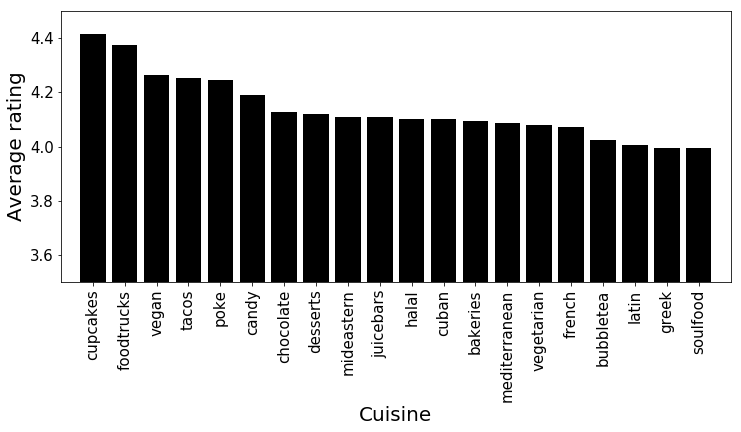

In [101]:
# Bar chart
N=20
plt.figure(figsize=(12,5))
plt.bar(np.arange(N), df_cuisines_rating['rating_avg'].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_cuisines_rating['cuisine'].values[:N])
plt.ylabel('Average rating', size=20)
plt.xlabel('Cuisine', size=20)
plt.xticks(size=15, rotation='vertical')
plt.yticks(size=15)
plt.ylim((3.5,4.5))
plt.xlim((-1, N))

(-1, 60)

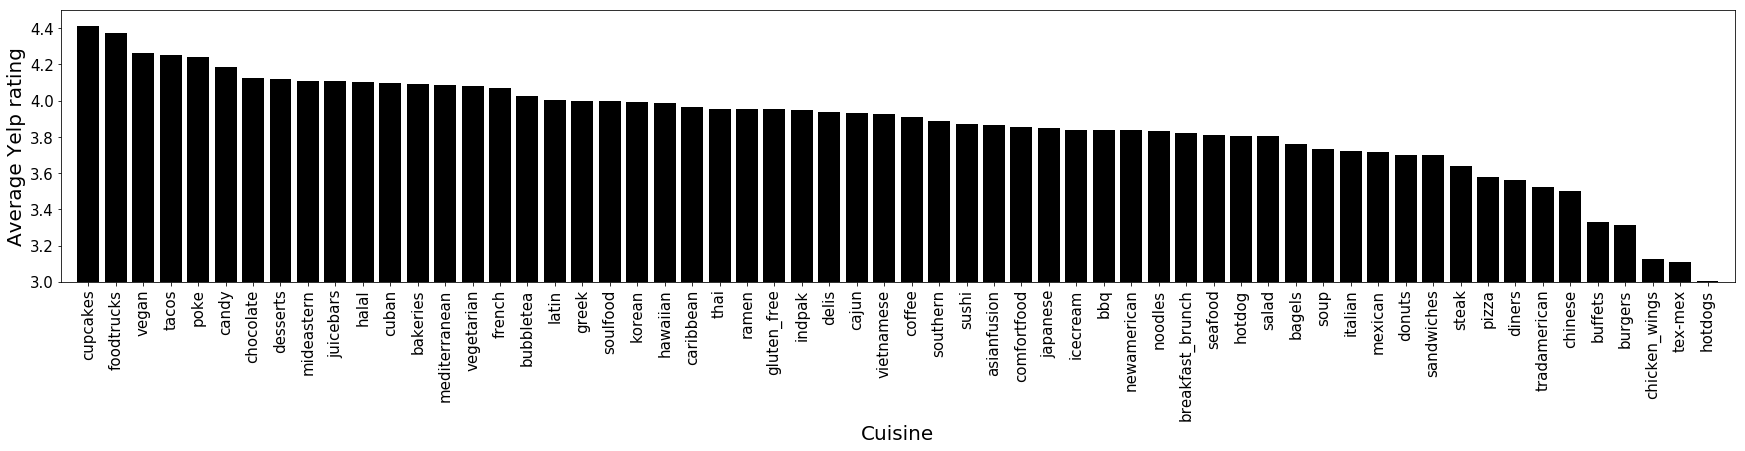

In [102]:
# Bar chart
N=60
plt.figure(figsize=(30,5))
plt.bar(np.arange(N), df_cuisines_rating['rating_avg'].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_cuisines_rating['cuisine'].values[:N])
plt.ylabel('Average Yelp rating', size=20)
plt.xlabel('Cuisine', size=20)
plt.xticks(size=15, rotation='vertical')
plt.yticks(size=15)
plt.ylim((3,4.5))
plt.xlim((-1, N))

# Most expensive and popular cuisines

(-1, 60)

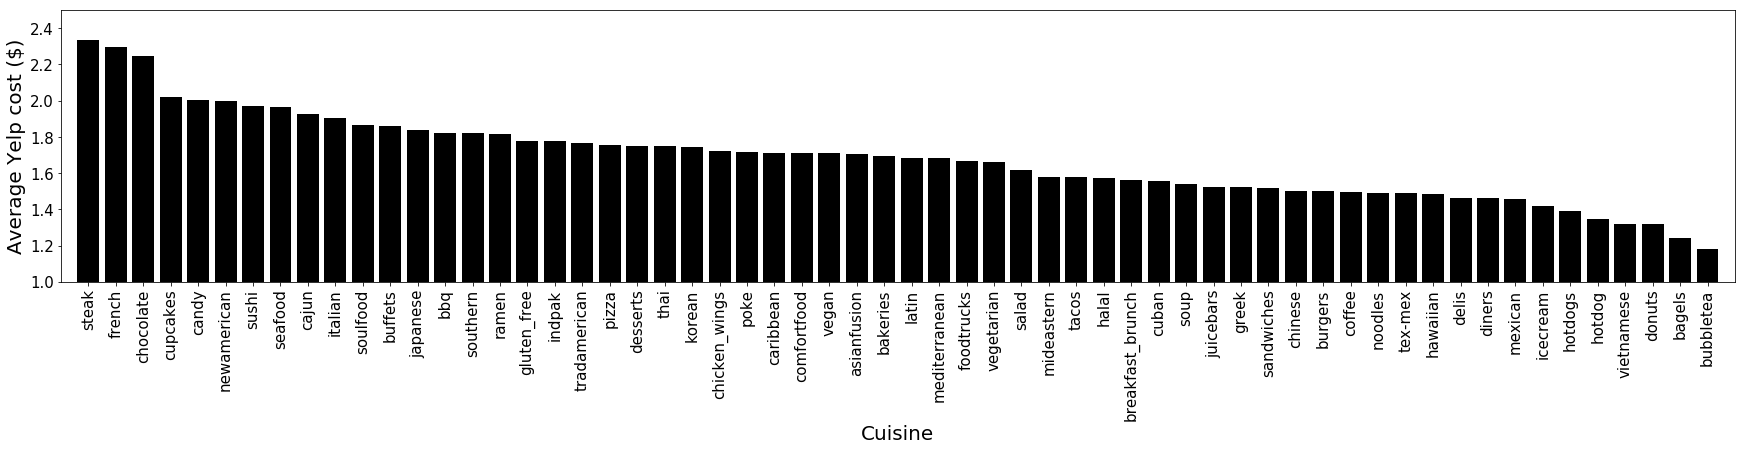

In [104]:
df_cuisines_rating.sort_values('cost_avg', ascending=False, inplace=True)
df_cuisines_rating.reset_index(drop=True, inplace=True)

N=60
plt.figure(figsize=(30,5))
plt.bar(np.arange(N), df_cuisines_rating['cost_avg'].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_cuisines_rating['cuisine'].values[:N])
plt.ylabel('Average Yelp cost ($)', size=20)
plt.xlabel('Cuisine', size=20)
plt.xticks(size=15, rotation='vertical')
plt.yticks(size=15)
plt.ylim((1,2.5))
plt.xlim((-1, N))

(-1, 60)

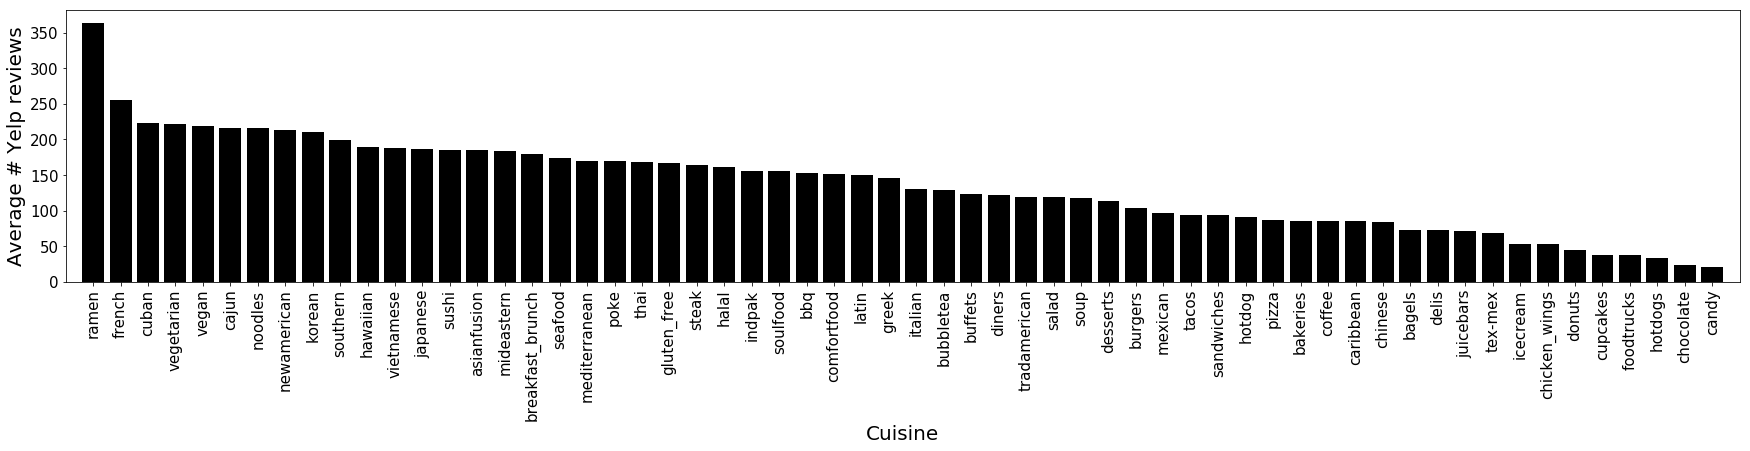

In [107]:
df_cuisines_rating.sort_values('Nreview_avg', ascending=False, inplace=True)
df_cuisines_rating.reset_index(drop=True, inplace=True)

N=60
plt.figure(figsize=(30,5))
plt.bar(np.arange(N), df_cuisines_rating['Nreview_avg'].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_cuisines_rating['cuisine'].values[:N])
plt.ylabel('Average # Yelp reviews', size=20)
plt.xlabel('Cuisine', size=20)
plt.xticks(size=15, rotation='vertical')
plt.yticks(size=15)
plt.xlim((-1, N))

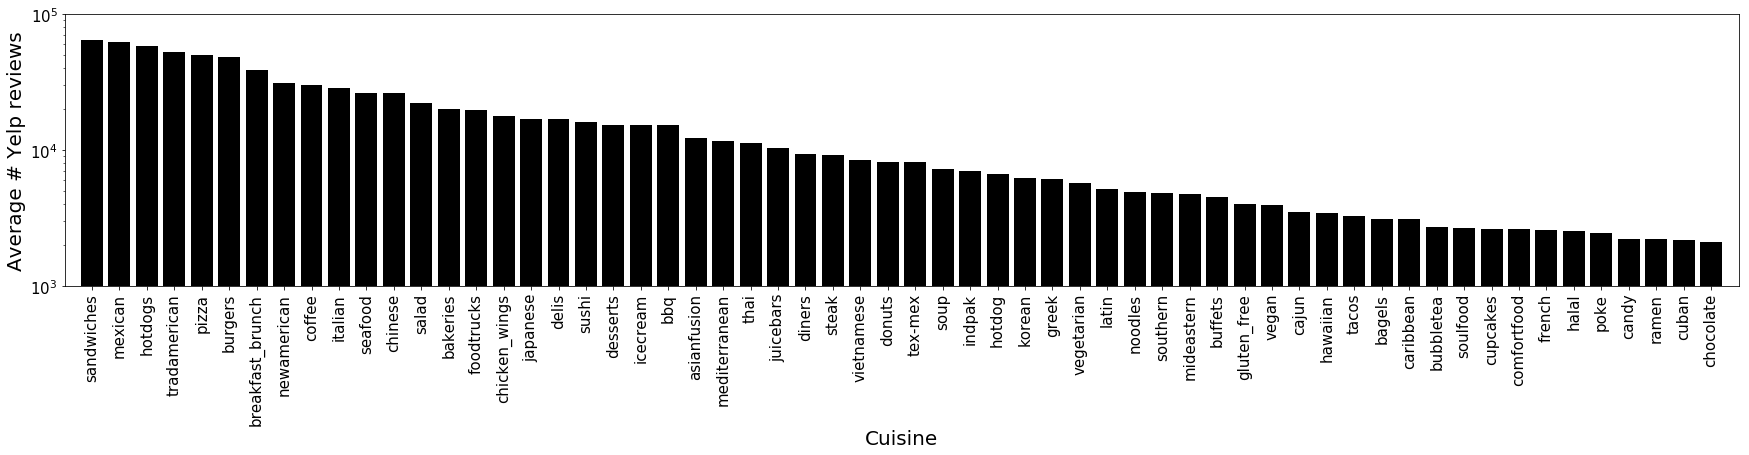

In [117]:
df_cuisines_rating.sort_values('N', ascending=False, inplace=True)
df_cuisines_rating.reset_index(drop=True, inplace=True)

N=60
plt.figure(figsize=(30,5))
plt.bar(np.arange(N), df_cuisines_rating['N'].values[:N], color='k', ecolor='.5')
plt.xticks(np.arange(N), df_cuisines_rating['cuisine'].values[:N])
plt.ylabel('Average # Yelp reviews', size=20)
plt.xlabel('Cuisine', size=20)
plt.xticks(size=15, rotation='vertical')
plt.yticks([10**3, 10**4, 10**5], size=15)
plt.ylim((10**3, 10**5))
plt.xlim((-1, N))

ax=plt.gca()
ax.set_yscale("log", nonposy='clip')